# Making the data Heterogeneous

In [1]:
import random
import torch
import math
import plotly.express as px
import pandas as pd
import numpy as np
from copy import deepcopy
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torch.utils.data import DataLoader, random_split, TensorDataset
import matplotlib.pyplot as plt

In [ ]:
import torchvision
import torchvision.transforms as transforms

# Transform the images to tensors
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Load CIFAR-10 training dataset
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

# Load CIFAR-10 testing dataset
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)


100%|██████████| 170498071/170498071 [00:02<00:00, 56939343.18it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
def get_cifar_iid(train_dataset, test_dataset, n_samples_train, n_samples_test, n_clients, shuffle=True):
    train_loaders = []
    test_loaders = []

    train_loader = DataLoader(train_dataset, batch_size=n_samples_train, shuffle=shuffle)
    test_loader = DataLoader(test_dataset, batch_size=n_samples_test, shuffle=shuffle)

    train_itr = iter(train_loader)
    test_itr = iter(test_loader)

    for i in range(n_clients):
        train_node_loader = DataLoader(TensorDataset(*(next(train_itr))), batch_size=25, shuffle=shuffle)
        test_node_loader = DataLoader(TensorDataset(*(next(test_itr))), batch_size=25, shuffle=shuffle)
        train_loaders.append(train_node_loader)
        test_loaders.append(test_node_loader)

    return train_loaders, test_loaders

In [4]:
def get_cifar_niid(train_dataset, test_dataset, n_samples_train, n_samples_test, n_clients, shuffle=True):
    def non_iid_split(dataset, nodes, samples_per_node, shuffle):
        num_of_labels = len(dataset.classes)
        node_labels = []
        labels_per_node = int(num_of_labels * 0.3)
        random.seed(213)
        for _ in range(nodes):
            node_labels.append(random.sample(range(num_of_labels), labels_per_node))
        loader = DataLoader(dataset, batch_size=nodes * samples_per_node, shuffle=shuffle)
        itr = iter(loader)
        images, labels = next(itr)
        data = []
        for i in range(nodes):
            is_label_equal = []
            for node_label in node_labels[i]:
                is_label_equal.append(node_label == labels)
            index = torch.stack(is_label_equal).sum(0)
            index = index.bool()
            node_dataloader_ = DataLoader(TensorDataset(images[index], labels[index]), batch_size=25, shuffle=shuffle)
            data.append(node_dataloader_)
        return data

    train_loaders = []
    test_loaders = []

    for _ in range(n_clients):
        train_node_loader = non_iid_split(train_dataset, 1, n_samples_train, shuffle)[0]
        test_node_loader = non_iid_split(test_dataset, 1, n_samples_test, shuffle)[0]
        train_loaders.append(train_node_loader)
        test_loaders.append(test_node_loader)

    return train_loaders, test_loaders


In [5]:
iid_train, iid_test = get_cifar_iid(train_dataset,test_dataset,n_samples_train =500,n_samples_test= 100, n_clients=10, shuffle=True)

iid_client = [iid_train, iid_test]

In [6]:
niid_train, niid_test = get_cifar_niid(train_dataset,test_dataset,n_samples_train =500,n_samples_test= 100, n_clients=10, shuffle=True)
niid_client = [niid_train, niid_test]

In [7]:
def plot_images(data, client_index):
    fig = plt.figure(figsize=(10, 10))
    X, y = next(iter(data[client_index]))
    for j in range(20):
        fig.add_subplot(5, 4, j+1)
        image = X[j].permute(1, 2, 0)
        image = image - image.min()
        image = image / image.max()

        plt.imshow(image)
        plt.axis('off')
    plt.show()

IID Training Dataset


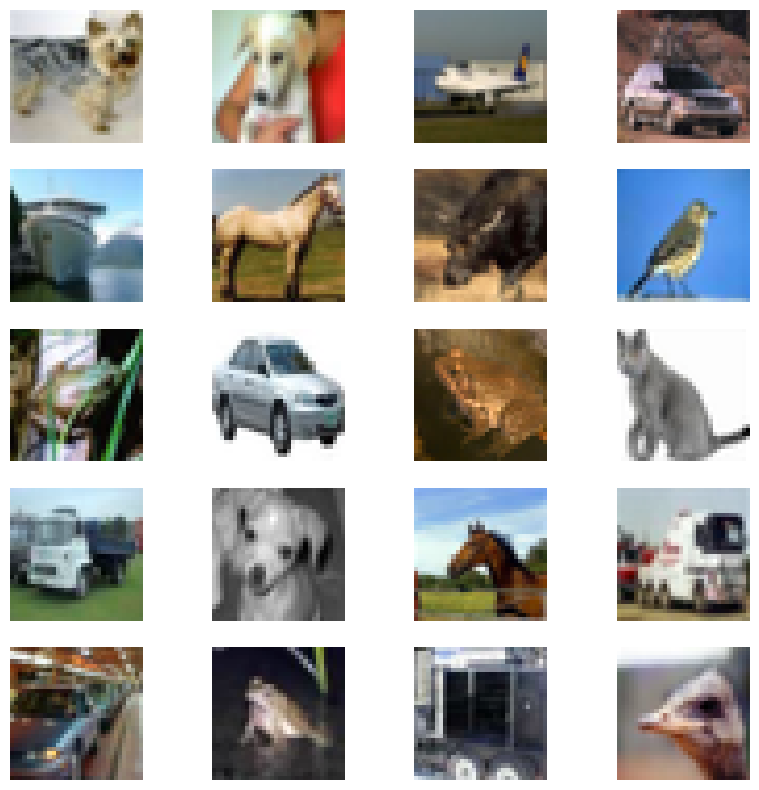

In [ ]:
print("IID Training Dataset")
plot_images(iid_train, 5)

Non-IID Training Dataset


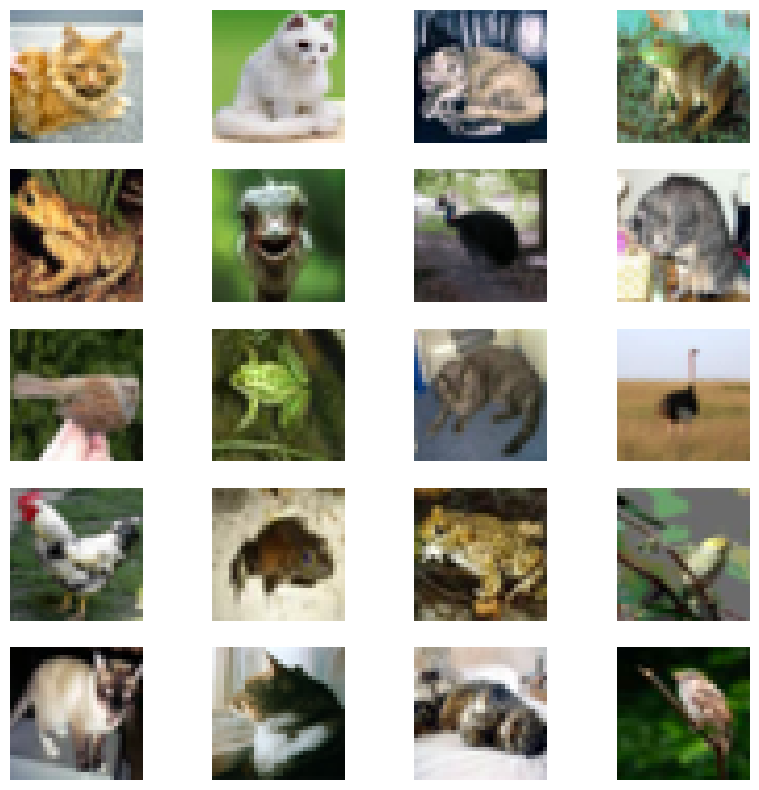

In [ ]:
print("Non-IID Training Dataset")
plot_images(niid_train, 4)

#Models and functions for federated learning algorithms

In [10]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool(torch.relu(self.bn2(self.conv2(x))))
        x = self.pool(torch.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = self.dropout(x)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model_0 = CNN()
model_1 = CNN()

In [11]:
sdA = model_0.state_dict()
sdB = model_1.state_dict()
sdC = sdA.copy()

for key in sdA:
    sdC[key] = (sdB[key] + sdA[key]) / 2

model_2 = CNN()
model_2.load_state_dict(sdC)


<All keys matched successfully>

In [12]:
def get_accuracy(predictions, labels):
     _, predicted = torch.max(predictions, dim=1)
     accuracy = torch.sum(predicted == labels).item()/len(predicted)
     return accuracy


In [13]:
def get_dataset_loss(model, dataset, loss_func):
    total_loss = 0
    for batch in dataset:
        features, labels = batch
        predictions = model(features)
        total_loss += loss_func(predictions, labels)

    avg_loss = total_loss/len(dataset)
    return avg_loss

In [14]:
def get_dataset_accuracy(model, dataset):

    total_accuracy = 0
    for batch in dataset:
        features, labels = batch
        predictions = model(features)
        curr_accuracy = get_accuracy(predictions, labels)
        total_accuracy += curr_accuracy

    avg_accuracy = (total_accuracy/len(dataset))*100
    return avg_accuracy


In [15]:
def diff_squared_sum(model1, model2):
    dss = 0
    for param1, param2 in zip(model1.parameters(), model2.parameters()):
        dss += torch.sum((param1 - param2) ** 2)
    return dss


In [16]:
def initialize_history():
    return {
        'loss': [],
        'accuracy': [],
        'model': []
    }

def log_server(history, model, client, loss_func):
    curr_loss = [(float)(get_dataset_loss(model, dataset, loss_func).detach()) for dataset in client[0]]
    history['loss'].append(sum(curr_loss)/len(curr_loss))
    curr_acc = [get_dataset_accuracy(model, dataset) for dataset in client[1]]
    history['accuracy'].append(sum(curr_acc)/len(curr_acc))
    history['model'].append(model.state_dict())

def log_client(history, model, dataset, loss):
    history['loss'].append(loss)
    curr_acc = get_dataset_accuracy(model, dataset)
    history['accuracy'].append(curr_acc)
    history['model'].append(model.state_dict())


In [17]:
def get_model_avg(history):
    model_states = history['model']
    avg_state = {}
    n = len(model_states)
    for key, value in model_states[0].items():
        avg_state[key] = torch.zeros_like(value)
    for state in model_states:
        for key, value in state.items():
            avg_state[key] += value
    for key, value in avg_state.items():
        avg_state[key] = avg_state[key].float() / torch.tensor(n, dtype=torch.float32)
    model = CNN()
    model.load_state_dict(avg_state)

    return model

#Training functions

In [18]:
history = initialize_history()

In [19]:
def clientUpdate(k, client, server_model, history, learning_rate, epochs, mu, loss_func, type, q):
    local_model = deepcopy(server_model)
    optimizer = torch.optim.SGD(local_model.parameters(), lr=learning_rate)

    for i in range(epochs):
        epoch_loss = 0
        for batch in client:
            images, labels = batch
            preds = local_model(images)
            loss = loss_func(preds, labels)
            if type == "prox":
                loss += (mu/2) * diff_squared_sum(local_model, server_model)
            epoch_loss += loss.item()

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss /= len(client)

    log_client(history, local_model, client, epoch_loss)

    return history


In [20]:
def Fed(server_model, clients, client_fraction=1, rounds=10, epochs=10, learning_rate=0.01, decay=1, type="avg", straggler_percent=0, mu=0, q=0):
    model = deepcopy(server_model)
    loss_func =  nn.CrossEntropyLoss(reduction="mean")
    K = len(clients[0])

    server_history = initialize_history()
    log_server(server_history, model, clients, loss_func)

    for i in range(rounds):
        m = max(math.floor(K*client_fraction), 1)
        s = random.sample(range(0, K), m)

        local_history = initialize_history()
        server_model = deepcopy(model)

        num_straggler = straggler_percent*len(s)
        straggler_epochs = max(int(epochs*(0.2)),1)
        for j in range(len(s)):

            if(j <= math.floor(len(s)-int(num_straggler))):
                local_history = clientUpdate(s[j], clients[0][s[j]], server_model, local_history,learning_rate, epochs, mu, loss_func, type, q=q)
            elif (type != "avg"):
                local_history = clientUpdate(s[j], clients[0][s[j]], server_model, local_history,learning_rate, straggler_epochs, mu, loss_func, type, q=q)


        model = get_model_avg(local_history)
        log_server(server_history, model, clients, loss_func)
    hist = server_history
    for i in range(len(hist['loss'])):
        if(i%(rounds/10) == 0):
            print("Loss: {:.4f}, Accuracy: {:.4f}".format(hist['loss'][i], hist['accuracy'][i]))
    return model, server_history

In [21]:
model = model_0
rounds = 20
epochs = 20
lr = 0.01
clt_frac= 0.5

In [22]:
def normal(delta_ws):

    w = (delta_ws[0]).pow(2).sum()
    b = (delta_ws[1]).pow(2).sum()

    ss = w + b
    return ss

In [23]:
def q_aggregate(server_model, deltas, hs):
    num_clients = len(deltas)
    de = np.sum(np.asarray(hs))
    scaled_deltas = []
    for client_delta in deltas:
        scaled_deltas.append([(layer * 1.0 / de) for layer in client_delta])

    model = deepcopy(server_model)

    with torch.no_grad():
        for layer_index, delta in enumerate(zip(*scaled_deltas)):
            layer_weights = getattr(model, f'conv{layer_index + 1}.weight', None) if layer_index < 2 else getattr(model, f'fc{layer_index - 1}.weight', None)
            layer_bias = getattr(model, f'conv{layer_index + 1}.bias', None) if layer_index < 2 else getattr(model, f'fc{layer_index - 1}.bias', None)

            if layer_weights is not None:
                delta_tensor = torch.tensor(delta)
                if delta_tensor.size() != layer_weights.size():
                    delta_tensor = delta_tensor.view(layer_weights.size())
                layer_weights -= delta_tensor[0]
                layer_bias -= delta_tensor[1]

    return model

In [24]:

def train(model, batch, loss_func):
    images, labels = batch
    preds = model(images)
    loss = loss_func(preds, labels)
    return loss

In [25]:

def q_clientUpdate(k, client, server_model, history, learning_rate, epochs, loss_func, type, q):
    local_model = deepcopy(server_model)
    local_loss = 0
    optimizer = torch.optim.SGD(local_model.parameters(), lr=learning_rate)

    for i in range(epochs):
        epoch_loss = 0

        for batch in client:
            loss = train(local_model, batch, loss_func)
            epoch_loss += loss

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        epoch_loss = epoch_loss/len(client)
        local_loss = epoch_loss

    history['loss'].append(local_loss.item())
    history['model'].append(local_model.state_dict())

    comp_loss = 0
    for batch in client:
        comp_loss += train(local_model, batch, loss_func)

    comp_loss = comp_loss/(len(client))

    delta_ws = [(x - y)*(1/learning_rate) for x, y in zip(server_model.state_dict().values(), local_model.state_dict().values())]
    q_loss = comp_loss.detach()
    delta = [np.float_power(q_loss + 1e-10, q) * delta_w for delta_w in delta_ws]
    h =  ((q * np.float_power(q_loss + 1e-10, (q-1)) * normal(delta_ws)) + ((1/learning_rate) * np.float_power(q_loss + 1e-10, q)))

    return history, delta, h

In [29]:
def qFed(server_model, clients, client_fraction=1, rounds=10, epochs=10, learning_rate=0.01, decay=1, type="sdg", straggler_percent=0, q=0):

    model = deepcopy(server_model)
    loss_func = nn.CrossEntropyLoss(reduction="mean")
    K = len(clients[0])
    server_history = initialize_history()
    log_server(server_history ,model, clients, loss_func)
    for i in range(rounds):

        m = max(math.floor(K*client_fraction), 1)

        s = random.sample(range(0, K), m)

        local_history = initialize_history()
        s_model = deepcopy(model)

        num_straggler = straggler_percent*len(s)
        straggler_epochs = max(int(epochs*(0.2)),1)
        deltas = []
        hs = []
        for j in range(len(s)):
            if(j <= math.floor(len(s)-int(num_straggler))):
                local_history, delta, h = q_clientUpdate(s[j], clients[0][s[j]], s_model, local_history,learning_rate, epochs, loss_func, type, q=q)
            else:
                local_history, delta, h = q_clientUpdate(s[j], clients[0][s[j]], s_model, local_history,learning_rate, straggler_epochs, loss_func, type, q=q)


            deltas.append(delta)
            hs.append(h)

        model = q_aggregate(s_model, deltas, hs)
        log_server(server_history,model, clients, loss_func)
    hist = server_history
    for i in range(len(hist['loss'])):
        if(i%(rounds/10) == 0):
            print("Loss: {:.4f}, Accuracy: {:.4f}".format(hist['loss'][i], hist['accuracy'][i]))
    return model, server_history


#iid

In [57]:
curr_clients = iid_client

In [58]:
qffl_iid_model_q, qffl_iid_hist_q = qFed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=20, learning_rate=0.1 ,q=4)

Loss: 2.3033, Accuracy: 9.8000
Loss: 0.7723, Accuracy: 78.4000
Loss: 0.3768, Accuracy: 87.3000
Loss: 0.3009, Accuracy: 88.7000
Loss: 0.2506, Accuracy: 89.7000
Loss: 0.2197, Accuracy: 90.4000
Loss: 0.1929, Accuracy: 91.6000
Loss: 0.1559, Accuracy: 92.8000
Loss: 0.1380, Accuracy: 93.8000
Loss: 0.1212, Accuracy: 93.5000
Loss: 0.1086, Accuracy: 94.7000


In [59]:
fprox_iid_model_0, fprox_iid_hist_0 = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0)

Loss: 2.3033, Accuracy: 9.8000
Loss: 0.7664, Accuracy: 80.0000
Loss: 0.3757, Accuracy: 88.0000
Loss: 0.3007, Accuracy: 88.9000
Loss: 0.2629, Accuracy: 89.7000
Loss: 0.2113, Accuracy: 91.1000
Loss: 0.1773, Accuracy: 92.2000
Loss: 0.1531, Accuracy: 93.1000
Loss: 0.1366, Accuracy: 92.9000
Loss: 0.1220, Accuracy: 93.4000
Loss: 0.1059, Accuracy: 93.8000


In [60]:
fprox_iid_model_mu, fprox_iid_hist_mu = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0.3)

Loss: 2.3033, Accuracy: 9.8000
Loss: 1.1826, Accuracy: 73.6000
Loss: 0.4348, Accuracy: 87.1000
Loss: 0.3474, Accuracy: 88.0000
Loss: 0.2950, Accuracy: 88.9000
Loss: 0.2528, Accuracy: 90.2000
Loss: 0.2222, Accuracy: 90.8000
Loss: 0.1903, Accuracy: 92.0000
Loss: 0.1717, Accuracy: 92.4000
Loss: 0.1498, Accuracy: 93.1000
Loss: 0.1411, Accuracy: 92.7000


In [61]:
favg_iid_model, favg_iid_hist = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="avg")

Loss: 2.3033, Accuracy: 9.8000
Loss: 2.3032, Accuracy: 9.8000
Loss: 2.3030, Accuracy: 9.8000
Loss: 2.3030, Accuracy: 9.8000
Loss: 2.3029, Accuracy: 9.8000
Loss: 2.3028, Accuracy: 9.8000
Loss: 2.3028, Accuracy: 9.8000
Loss: 2.3028, Accuracy: 9.8000
Loss: 2.3026, Accuracy: 9.8000
Loss: 2.3024, Accuracy: 9.8000
Loss: 2.3023, Accuracy: 9.8000


In [62]:
losses = [favg_iid_hist['loss'], fprox_iid_hist_0['loss'], fprox_iid_hist_mu['loss'], qffl_iid_hist_q['loss']]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)", "q-FedAvg(q>0)"]
df = pd.DataFrame(np.column_stack(losses), columns=line_names)
fig = px.line(df,
              x=list(range(0, len(losses[0]))),
              y=df.columns[:],
              labels={"x": "Rounds", "value": "Loss"},
              title="Comparing different Fed Algorithms on IID Dataset"
             )
fig.show()

In [63]:
acc = [favg_iid_hist['accuracy'], fprox_iid_hist_0['accuracy'], fprox_iid_hist_mu['accuracy'], qffl_iid_hist_q['accuracy']]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)", "q-FedAvg(q>0)"]
df = pd.DataFrame(np.column_stack(acc), columns=line_names)
fig = px.line(df,
              x=list(range(0, len(acc[0]))),
              y=df.columns[:],
              labels={"x": "Rounds", "value": "Accuracy"},
              title="Comparing different Fed Algorithms on IID Dataset"
             )
fig.show()

#for non_iid

In [40]:
curr_nclients = niid_client

In [41]:
qffl_iid_model_q, qffl_iid_hist_q = qFed(server_model=model, clients=curr_nclients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=10, learning_rate=0.1 ,q=5)

Loss: 2.2945, Accuracy: 33.0184
Loss: 0.6419, Accuracy: 91.8224
Loss: 0.2055, Accuracy: 93.8589
Loss: 0.1655, Accuracy: 95.3911
Loss: 0.1059, Accuracy: 96.7732
Loss: 0.0932, Accuracy: 96.6875
Loss: 0.0911, Accuracy: 97.2875
Loss: 0.1090, Accuracy: 96.3402
Loss: 0.0723, Accuracy: 98.0000
Loss: 0.0720, Accuracy: 96.8000
Loss: 0.0658, Accuracy: 92.5875


In [42]:
fprox_iid_model_0, fprox_iid_hist_0 = Fed(server_model=model, clients=curr_nclients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0)

Loss: 2.2924, Accuracy: 35.4428
Loss: 0.6252, Accuracy: 93.6527
Loss: 0.1909, Accuracy: 94.8607
Loss: 0.1406, Accuracy: 94.0857
Loss: 0.1461, Accuracy: 95.4769
Loss: 0.1070, Accuracy: 95.6857
Loss: 0.0861, Accuracy: 95.5732
Loss: 0.0767, Accuracy: 96.3750
Loss: 0.0825, Accuracy: 94.6509
Loss: 0.0724, Accuracy: 97.2000
Loss: 0.0621, Accuracy: 96.9732


In [43]:
favg_iid_model, favg_iid_hist = Fed(server_model=model, clients=curr_nclients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="avg")

Loss: 2.2945, Accuracy: 27.0750
Loss: 2.2481, Accuracy: 27.9708
Loss: 2.2325, Accuracy: 32.3833
Loss: 2.2119, Accuracy: 32.1785
Loss: 2.1945, Accuracy: 32.8416
Loss: 2.1805, Accuracy: 33.8309
Loss: 2.1556, Accuracy: 31.1291
Loss: 0.5826, Accuracy: 78.5533
Loss: 0.5755, Accuracy: 72.8575
Loss: 0.5218, Accuracy: 76.8676
Loss: 0.5025, Accuracy: 74.6438


In [44]:
fprox_iid_model_mu, fprox_iid_hist_mu = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0.3)

Loss: 2.3033, Accuracy: 9.8000
Loss: 1.2248, Accuracy: 73.3000
Loss: 0.4270, Accuracy: 86.6000
Loss: 0.3358, Accuracy: 87.7000
Loss: 0.2984, Accuracy: 89.8000
Loss: 0.2514, Accuracy: 90.6000
Loss: 0.2213, Accuracy: 91.3000
Loss: 0.1930, Accuracy: 91.8000
Loss: 0.1711, Accuracy: 92.9000
Loss: 0.1547, Accuracy: 92.5000
Loss: 0.1409, Accuracy: 93.0000


In [52]:
losses = [favg_iid_hist['loss'], fprox_iid_hist_0['loss'], fprox_iid_hist_mu['loss'], qffl_iid_hist_q['loss']]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)", "q-FedAvg(q>0)"]
title = "Comparing different Fed Algorithms on IID Dataset"
df = pd.DataFrame(np.column_stack(losses), columns=line_names)
fig = px.line(df,
              x=list(range(0, len(losses[0]))),
              y=df.columns[:],
              labels={"x": "Rounds", "value": "Loss"},
              title=title
             )
fig.show()

In [54]:
acc = [favg_iid_hist['accuracy'], fprox_iid_hist_0['accuracy'], fprox_iid_hist_mu['accuracy'], qffl_iid_hist_q['accuracy']]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)", "q-FedAvg(q>0)"]
title = "Comparing different Fed Algorithms on IID Dataset"
df = pd.DataFrame(np.column_stack(acc), columns=line_names)
fig = px.line(df,
              x=list(range(0, len(acc[0]))),
              y=df.columns[:],
              labels={"x": "Rounds", "value": "Accuracy"},
              title=title
             )
fig.show()

# 0.5 stragglers for iid

In [64]:
qffl_iid_model_q, qffl_iid_hist_q = qFed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=0.1, straggler_percent=0.5, q=5)

Loss: 2.3033, Accuracy: 9.8000
Loss: 0.7802, Accuracy: 78.0000
Loss: 0.4063, Accuracy: 86.9000
Loss: 0.2996, Accuracy: 89.4000
Loss: 0.2520, Accuracy: 90.4000
Loss: 0.2153, Accuracy: 91.2000
Loss: 0.1889, Accuracy: 92.2000
Loss: 0.1593, Accuracy: 91.9000
Loss: 0.1402, Accuracy: 93.4000
Loss: 0.1208, Accuracy: 93.9000
Loss: 0.1113, Accuracy: 93.9000


In [65]:

fprox_iid_model_0, fprox_iid_hist_0 = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0,
                                    straggler_percent=0.5)

Loss: 2.3033, Accuracy: 9.8000
Loss: 1.0953, Accuracy: 74.9000
Loss: 0.4125, Accuracy: 86.2000
Loss: 0.3233, Accuracy: 88.6000
Loss: 0.2698, Accuracy: 89.6000
Loss: 0.2308, Accuracy: 91.1000
Loss: 0.2042, Accuracy: 91.4000
Loss: 0.1780, Accuracy: 92.3000
Loss: 0.1572, Accuracy: 92.3000
Loss: 0.1483, Accuracy: 93.0000
Loss: 0.1270, Accuracy: 93.8000


In [66]:
favg_iid_model, favg_iid_hist = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="avg",
                                    straggler_percent=0.5)

Loss: 2.3033, Accuracy: 9.8000
Loss: 2.2509, Accuracy: 15.4000
Loss: 2.1965, Accuracy: 36.0000
Loss: 2.1304, Accuracy: 50.4000
Loss: 2.0333, Accuracy: 68.4000
Loss: 1.9427, Accuracy: 73.7000
Loss: 1.8547, Accuracy: 77.4000
Loss: 1.7638, Accuracy: 78.2000
Loss: 1.5661, Accuracy: 78.7000
Loss: 1.4867, Accuracy: 79.8000
Loss: 1.3848, Accuracy: 81.4000


In [67]:
fprox_iid_model_mu, fprox_iid_hist_mu = Fed(server_model=model, clients=curr_clients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0.3,
                                    straggler_percent=0.5)

Loss: 2.3033, Accuracy: 9.8000
Loss: 1.6113, Accuracy: 71.2000
Loss: 0.5021, Accuracy: 84.5000
Loss: 0.3704, Accuracy: 87.8000
Loss: 0.3234, Accuracy: 88.9000
Loss: 0.2771, Accuracy: 89.5000
Loss: 0.2513, Accuracy: 90.6000
Loss: 0.2215, Accuracy: 90.8000
Loss: 0.1993, Accuracy: 91.4000
Loss: 0.1794, Accuracy: 92.5000
Loss: 0.1586, Accuracy: 92.6000


In [68]:
losses = [favg_iid_hist['loss'], fprox_iid_hist_0['loss'], fprox_iid_hist_mu['loss'], qffl_iid_hist_q['loss']]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)", "q-FedAvg(q>0)"]
title = "Comparing different Fed Algorithms on IID Dataset"
df = pd.DataFrame(np.column_stack(losses), columns=line_names)
fig = px.line(df,
              x=list(range(0, len(losses[0]))),
              y=df.columns[:],
              labels={"x": "Rounds", "value": "Loss"},
              title=title
             )
fig.show()

In [69]:
acc = [favg_iid_hist['accuracy'], fprox_iid_hist_0['accuracy'], fprox_iid_hist_mu['accuracy'], qffl_iid_hist_q['accuracy']]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)", "q-FedAvg(q>0)"]
title = "Comparing different Fed Algorithms on IID Dataset"
df = pd.DataFrame(np.column_stack(acc), columns=line_names)
fig = px.line(df,
              x=list(range(0, len(acc[0]))),
              y=df.columns[:],
              labels={"x": "Rounds", "value": "Accuracy"},
              title=title
             )
fig.show()

# 0.5 stragglers for non_iid

In [71]:
fprox_iid_model_mu, fprox_iid_hist_mu = Fed(server_model=model, clients=curr_nclients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0.3,
                                    straggler_percent=0.5)

Loss: 2.2922, Accuracy: 29.5018
Loss: 1.6317, Accuracy: 41.8956
Loss: 1.2116, Accuracy: 44.8789
Loss: 1.0200, Accuracy: 51.3876
Loss: 1.0309, Accuracy: 44.7276
Loss: 0.8926, Accuracy: 58.7463
Loss: 0.5655, Accuracy: 80.5520
Loss: 1.1911, Accuracy: 53.0583
Loss: 0.6907, Accuracy: 76.0348
Loss: 0.4899, Accuracy: 86.0216
Loss: 0.3458, Accuracy: 91.9429


In [72]:
fprox_iid_model_0, fprox_iid_hist_0 = Fed(server_model=model, clients=curr_nclients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="prox", mu=0,
                                    straggler_percent=0.5)

Loss: 2.2935, Accuracy: 29.5101
Loss: 0.7228, Accuracy: 87.4535
Loss: 0.2370, Accuracy: 95.5482
Loss: 0.1463, Accuracy: 93.1732
Loss: 0.1208, Accuracy: 96.7750
Loss: 0.1052, Accuracy: 97.7750
Loss: 0.0983, Accuracy: 95.7482
Loss: 0.0852, Accuracy: 98.2000
Loss: 0.0800, Accuracy: 95.1875
Loss: 0.0749, Accuracy: 93.5875
Loss: 0.0747, Accuracy: 94.5875


In [73]:
favg_iid_model, favg_iid_hist = Fed(server_model=model, clients=curr_nclients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=lr, type="avg",
                                    straggler_percent=0.5)

Loss: 2.2927, Accuracy: 31.1125
Loss: 0.6274, Accuracy: 95.5750
Loss: 0.1962, Accuracy: 94.2589
Loss: 0.1268, Accuracy: 95.6607
Loss: 0.1067, Accuracy: 95.1732
Loss: 0.0936, Accuracy: 95.4607
Loss: 0.1085, Accuracy: 96.8259
Loss: 0.0780, Accuracy: 98.8000
Loss: 0.0805, Accuracy: 96.1750
Loss: 0.0726, Accuracy: 96.7732
Loss: 0.1068, Accuracy: 96.5134


In [75]:
qffl_iid_model_q, qffl_iid_hist_q = qFed(server_model=model, clients=curr_nclients, client_fraction=clt_frac,
                                    rounds=rounds, epochs=epochs, learning_rate=0.1, straggler_percent=0.5, q=5)

Loss: 2.2952, Accuracy: 33.4327
Loss: 0.7632, Accuracy: 90.2450
Loss: 0.2756, Accuracy: 96.6875
Loss: 0.1699, Accuracy: 94.8875
Loss: 0.1323, Accuracy: 95.4857
Loss: 0.1110, Accuracy: 95.5750
Loss: 0.1012, Accuracy: 95.4607
Loss: 0.0879, Accuracy: 96.7732
Loss: 0.0822, Accuracy: 98.2875
Loss: 0.0784, Accuracy: 96.9750
Loss: 0.0772, Accuracy: 98.0875


In [80]:
losses = [favg_iid_hist['loss'], fprox_iid_hist_0['loss'], fprox_iid_hist_mu['loss'], qffl_iid_hist_q['loss']]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)", "q-FedAvg(q>0)"]
title = "Comparing different Fed Algorithms on IID Dataset"
df = pd.DataFrame(np.column_stack(losses), columns=line_names)
fig = px.line(df,
              x=list(range(0, len(acc[0]))),
              y=df.columns[:],
              labels={"x": "Rounds", "value": "Accuracy"},
              title=title
             )
fig.show()

In [81]:
acc = [favg_iid_hist['accuracy'], fprox_iid_hist_0['accuracy'], fprox_iid_hist_mu['accuracy'], qffl_iid_hist_q['accuracy']]
line_names = ["FedAvg", "FedProx(mu=0)", "FedProx(mu>0)", "q-FedAvg(q>0)"]
title = "Comparing different Fed Algorithms on IID Dataset"
df = pd.DataFrame(np.column_stack(acc), columns=line_names)
fig = px.line(df,
              x=list(range(0, len(acc[0]))),
              y=df.columns[:],
              labels={"x": "Rounds", "value": "Accuracy"},
              title=title
             )
fig.show()